In [19]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from pathlib import Path,PurePath
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from model import *
import util



In [20]:
parser = argparse.ArgumentParser()
parser.add_argument('--device',type=str,default='cuda:0',help='')
parser.add_argument('--data',type=str,default='../data/METR-LA',help='data path')
parser.add_argument('--adjdata',type=str,default='../data/sensor_graph/adj_mx.pkl',help='adj data path')
parser.add_argument('--adjtype',type=str,default='doubletransition',help='adj type')
parser.add_argument('--gcn_bool',action='store_true',help='whether to add graph convolution layer')
parser.add_argument('--aptonly',action='store_true',help='whether only adaptive adj')
parser.add_argument('--addaptadj',action='store_true',help='whether add adaptive adj')
parser.add_argument('--randomadj',action='store_true',help='whether random initialize adaptive adj')
parser.add_argument('--seq_length',type=int,default=12,help='')
parser.add_argument('--nhid',type=int,default=32,help='')
parser.add_argument('--in_dim',type=int,default=2,help='inputs dimension')
parser.add_argument('--num_nodes',type=int,default=207,help='number of nodes')
parser.add_argument('--batch_size',type=int,default=64,help='batch size')
parser.add_argument('--learning_rate',type=float,default=0.001,help='learning rate')
parser.add_argument('--dropout',type=float,default=0.3,help='dropout rate')
parser.add_argument('--weight_decay',type=float,default=0.0001,help='weight decay rate')
parser.add_argument('--checkpoint',type=str, default='../garage/metr-la_exp1_best_2.73.pth', help='')
parser.add_argument('--plotheatmap',type=str,default='True',help='')


args = parser.parse_args('')

In [21]:
device = torch.device(args.device)

_, _, adj_mx = util.load_adj(args.adjdata, args.adjtype)
supports = [torch.tensor(i).to(device) for i in adj_mx]
if args.randomadj:
    adjinit = None
else:
    adjinit = supports[0]

if args.aptonly:
    supports = None

model =  gwnet(device, args.num_nodes, args.dropout, supports=supports, gcn_bool=True, addaptadj=True, aptinit=adjinit)
model.to(device)
model.load_state_dict(torch.load(args.checkpoint))
model.eval()
print('model load successfully')
    


model load successfully


In [22]:
dataloader = util.load_dataset(args.data, args.batch_size, args.batch_size, args.batch_size)
scaler = dataloader['scaler']
outputs = []
predList = []
realList = []
realy = torch.Tensor(dataloader['y_test']).to(device)
realy = realy.transpose(1,3)[:,0,:,:]

for iter, (x, y) in enumerate(dataloader['test_loader'].get_iterator()):
    testx = torch.Tensor(x).to(device)
    testx = testx.transpose(1,3)
    with torch.no_grad():
        preds = model(testx).transpose(1,3)
    outputs.append(preds.squeeze())

yhat = torch.cat(outputs,dim=0)
yhat = yhat[:realy.size(0),...]


amae = []
amape = []
armse = []
horizon_dict = {}
for i in range(12):
    pred = scaler.inverse_transform(yhat[:,:,i])
    real = realy[:,:,i]
    predList.append(pred.cpu().detach().numpy())
    realList.append(real.cpu().detach().numpy())

    metrics = util.metric(pred,real)
    log = 'Evaluate best model on test data for horizon {:d}, Test MAE: {:.4f}, Test MAPE: {:.4f}, Test RMSE: {:.4f}'
    print(log.format(i+1, metrics[0], metrics[1], metrics[2]))
    amae.append(metrics[0])
    amape.append(metrics[1])
    armse.append(metrics[2])

horizon_dict['Horizon'] = ['{} mins'.format(a) for a in range(5, 61, 5)]
horizon_dict['MAE'] = amae
horizon_dict['RMSE'] = armse
horizon_dict['MAPE'] = amape
log = 'On average over 12 horizons, Test MAE: {:.4f}, Test MAPE: {:.4f}, Test RMSE: {:.4f}'
print(log.format(np.mean(amae),np.mean(amape),np.mean(armse)))

Evaluate best model on test data for horizon 1, Test MAE: 2.2306, Test MAPE: 0.0537, Test RMSE: 3.8647
Evaluate best model on test data for horizon 2, Test MAE: 2.5099, Test MAPE: 0.0629, Test RMSE: 4.6563
Evaluate best model on test data for horizon 3, Test MAE: 2.7000, Test MAPE: 0.0696, Test RMSE: 5.1837
Evaluate best model on test data for horizon 4, Test MAE: 2.8556, Test MAPE: 0.0752, Test RMSE: 5.6013
Evaluate best model on test data for horizon 5, Test MAE: 2.9792, Test MAPE: 0.0797, Test RMSE: 5.9339
Evaluate best model on test data for horizon 6, Test MAE: 3.0843, Test MAPE: 0.0836, Test RMSE: 6.2027
Evaluate best model on test data for horizon 7, Test MAE: 3.1781, Test MAPE: 0.0870, Test RMSE: 6.4386
Evaluate best model on test data for horizon 8, Test MAE: 3.2602, Test MAPE: 0.0901, Test RMSE: 6.6414
Evaluate best model on test data for horizon 9, Test MAE: 3.3329, Test MAPE: 0.0926, Test RMSE: 6.8171
Evaluate best model on test data for horizon 10, Test MAE: 3.3963, Test M

In [23]:
def plot_time(df, dataset_name='METR-LA', id_range=5,  start=0, end=12, horizon=0):
    fig, ax = plt.subplots(figsize=(30, 10))
    for i in range(id_range):
        ax.plot(df[i][start:end], label='Node ID: {}'.format(i))
    ax.legend()
    ax.set_title('Speeds Recorded for Nodes ({})'.format(dataset_name))
    ax.set_ylabel('Speed')
    ax.set_xlabel('Time Intervals(1 interval=5mins) at {} horizon'.format(horizon+1))
    # ax.set_xlabel('Time Intervals(1 interval=5mins)')
    plt.show()

In [24]:
def plot_time_compare(predList, realList, dataset_name='METR-LA', start=0, end=12, node_id=0, horizon=0, pred=True):
  df_pred = pd.DataFrame(predList[horizon])
  df_real = pd.DataFrame(realList[horizon])
  fig, ax = plt.subplots(figsize=(30, 10))
  if pred:
    ax.plot(df_pred[node_id][start:end], label='Pred horizon ID: {}'.format(node_id))
  ax.plot(df_real[node_id][start:end], label='Real Node ID: {}'.format(node_id))
  ax.legend()
  ax.set_title('Speeds Recorded for Nodes ({})'.format(dataset_name))
  ax.set_ylabel('Speed')
  ax.set_xlabel('Time Intervals(1 interval=5mins) at {} horizon'.format(horizon+1))
  plt.show()

In [25]:
def plot_dependencies(realList, dataset_name='METR-LA', start=0, end=12, node_A=0, node_B=0, horizon=0):
  df_real = pd.DataFrame(realList[horizon])
  fig, ax = plt.subplots(figsize=(30, 10))
  ax.plot(df_real[node_A][start:end], label='Node ID: {}'.format(node_A), color='r')
  ax.plot(df_real[node_B][start:end], label='Node ID: {}'.format(node_B), color='g')
  ax.legend()
  ax.set_title('Speeds Recorded for Nodes ({})'.format(dataset_name))
  ax.set_ylabel('Speed')
  ax.set_xlabel('Time Intervals(1 interval=5mins) at {} horizon'.format(horizon+1))
  plt.show()

In [26]:
df_metrics = pd.DataFrame(horizon_dict)
df_metrics['MAPE'] = df_metrics['MAPE'] * 100
df_metrics = df_metrics.round(2)

In [27]:
df_metrics  

,Horizon,MAE,RMSE,MAPE
0,5 mins,2.23,3.86,5.37
1,10 mins,2.51,4.66,6.29
2,15 mins,2.70,5.18,6.96
3,20 mins,2.86,5.60,7.52
4,25 mins,2.98,5.93,7.97
5,30 mins,3.08,6.20,8.36
6,35 mins,3.18,6.44,8.70
7,40 mins,3.26,6.64,9.01
8,45 mins,3.33,6.82,9.26
9,50 mins,3.40,6.97,9.51


In [28]:
df_metrics.std()

MAE     0.402111
RMSE    1.054311
MAPE    1.451722
dtype: float64

In [29]:
df_metrics.mean()

MAE     3.042500
RMSE    6.055000
MAPE    8.226667
dtype: float64

In [30]:
np.savez_compressed(
            PurePath('../results/predictions.npz'),
            real=realList,
            pred=predList,
            )

In [31]:
#  24hrs=288*1, 48hrs=288*2, 72hrs=288*3
start = 0
end = 288*3  #108
horizon = 11
node_id = 5

In [32]:
df_pred = pd.DataFrame(predList[horizon])
df_real = pd.DataFrame(realList[horizon])

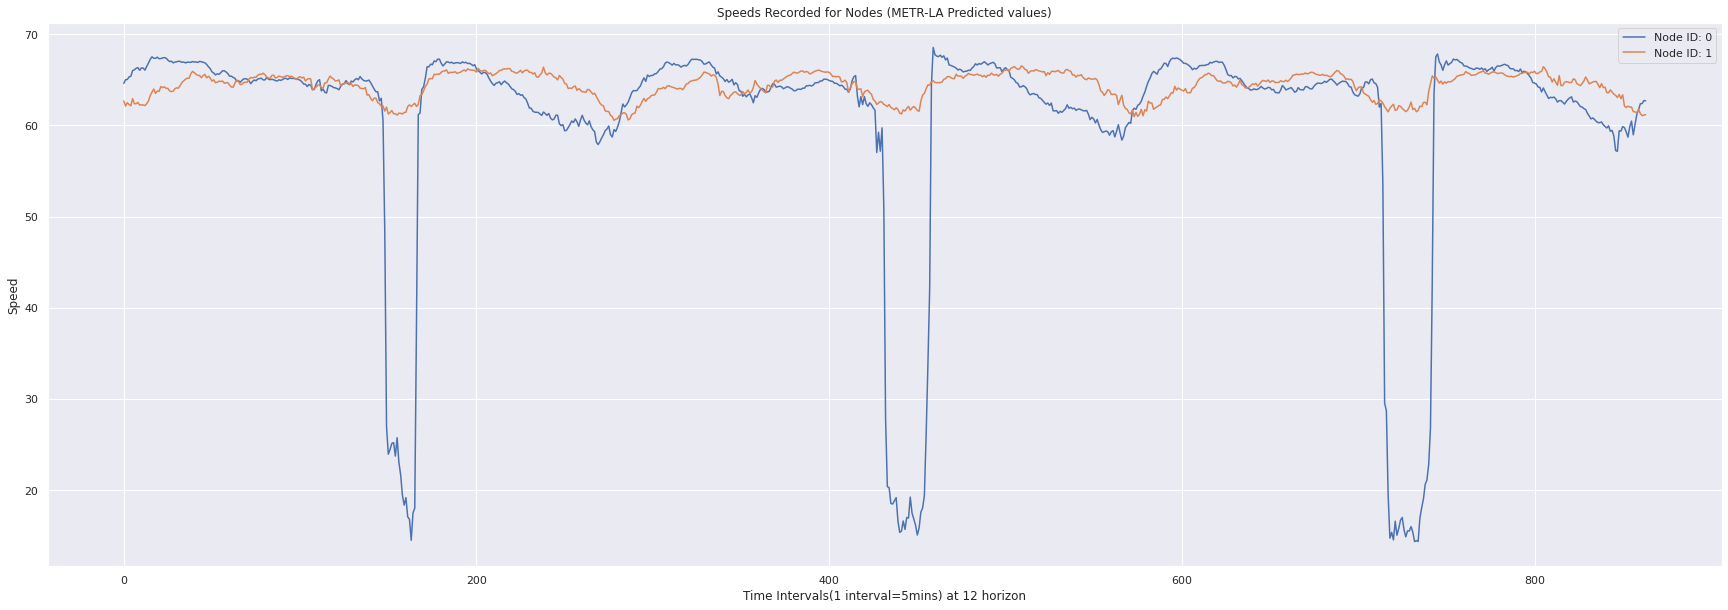

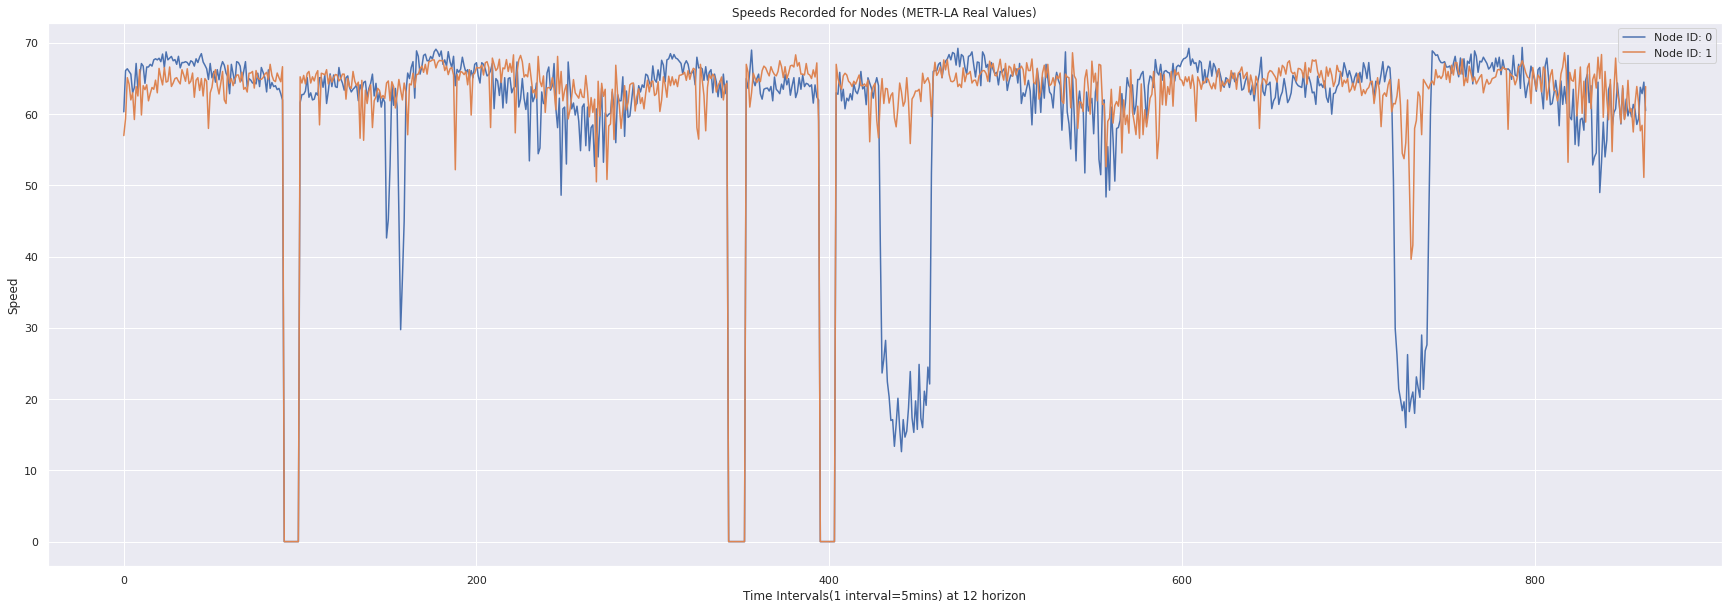

In [54]:
plot_time(df=df_pred, dataset_name='METR-LA Predicted values', id_range=2, start=start, end=end, horizon=horizon) 
plot_time(df=df_real, dataset_name='METR-LA Real Values', id_range=2, start=start, end=end, horizon=horizon)


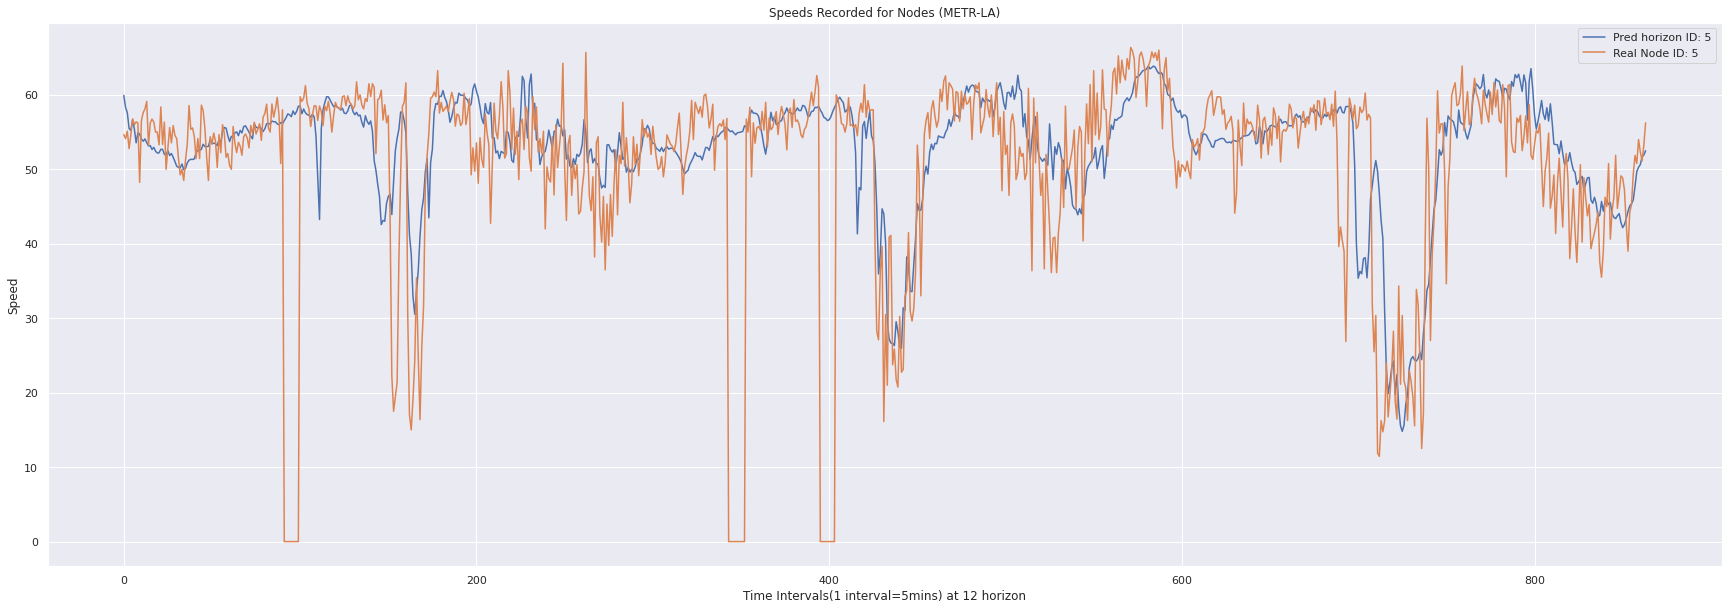

In [34]:
plot_time_compare(predList=predList, realList=realList, start=start, end=end, node_id=node_id, horizon=horizon)

### Fig 3. Prediction data vs Test data for Node 1 (72hr period)
- The Model is able to predict the correct values. However, it cannot account for when there is no traffic being recorded at the node

In [35]:
print('The standard deviation values for the Predicted nodes are\n', df_pred.std()[:5])
print('The standard deviation values for the Predicted nodes are\n', df_real.std()[:5])

The standard deviation values for the Predicted nodes are
 0    12.130571
1     1.466655
2     9.958584
3     8.132169
4    13.863317
dtype: float32
The standard deviation values for the Predicted nodes are
 0    22.086756
1    19.356901
2    21.309414
3    18.040911
4    21.634510
dtype: float32


In [36]:
print('The mean values for the Predicted nodes are\n', df_pred.mean()[:5])
print('The mean values for the Predicted nodes are\n', df_real.mean()[:5])

The mean values for the Predicted nodes are
 0    61.470375
1    64.757812
2    64.825211
3    52.775734
4    48.910629
dtype: float32
The mean values for the Predicted nodes are
 0    54.779102
1    58.223618
2    58.480721
3    47.261707
4    41.741451
dtype: float32


In [52]:
df_pred

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,64.609818,62.686043,67.583740,58.454140,65.958061,59.936165,64.677925,62.309650,61.843086,67.447083,...,43.394737,66.448181,57.642105,63.045135,62.969780,62.038231,65.186401,65.060310,64.357552,64.077118
1,65.012405,62.124126,67.640945,58.399723,65.794479,58.324329,64.879814,62.411095,62.092754,67.287369,...,43.544636,66.564270,58.548717,63.939663,62.925938,61.992138,65.301804,65.003029,64.698143,64.192993
2,65.037689,62.496124,67.371300,58.122070,66.027740,57.606953,64.505417,62.496185,62.388393,67.423050,...,44.064678,66.616669,58.465401,64.381989,63.631409,61.672367,65.396416,64.852661,64.557945,64.337120
3,65.324615,62.288078,67.662582,57.903934,65.779984,55.496124,64.471519,62.299911,61.645050,67.560661,...,45.115005,66.835060,58.889893,64.359764,64.211548,61.774048,65.583542,65.050598,64.790802,64.633629
4,65.393188,62.152962,67.524925,57.870136,66.014900,55.215336,64.705948,62.049652,61.219830,67.282471,...,45.285019,67.035957,59.405544,64.621452,64.742020,62.121513,65.413269,65.475372,64.605492,64.847130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6845,65.137100,65.468979,67.754280,60.527985,66.332390,59.873421,62.907341,65.136894,61.062008,65.449066,...,46.687611,68.435692,63.713425,60.685795,66.339279,63.266479,67.647621,64.519279,67.491020,63.099586
6846,65.063934,65.509918,67.295929,58.940258,66.408363,59.677704,62.978355,65.091492,60.562870,65.399002,...,46.385544,68.352730,63.484467,59.665222,66.035294,62.546597,67.336914,64.565582,67.752563,62.885296
6847,65.544846,65.358864,67.461639,59.193813,66.191170,60.110416,63.404701,65.243561,60.793961,65.043198,...,47.104778,68.494308,63.792179,59.766445,66.037407,62.845215,67.721718,64.567902,67.780914,63.034603
6848,65.042221,65.501312,66.997047,60.427681,65.675568,62.200066,63.322582,65.026176,60.791698,64.981056,...,47.226234,68.526779,63.304768,59.829304,65.654182,62.499264,67.659035,64.502151,67.757568,62.742424


<AxesSubplot:>

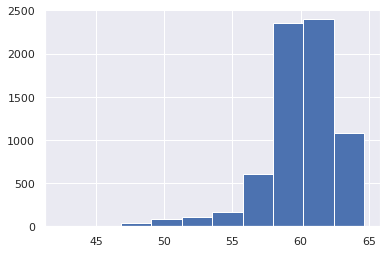

In [48]:
df_pred[30].hist()

<AxesSubplot:>

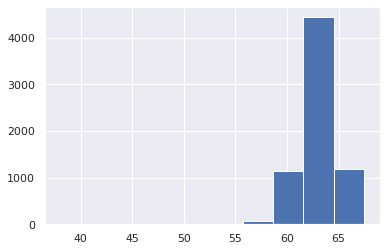

In [49]:
df_pred[65].hist()

In [18]:
adp = F.softmax(F.relu(torch.mm(model.nodevec1, model.nodevec2)), dim=1)

In [19]:
adp = adp.cpu().detach().numpy()

In [20]:
adp = adp*(1/np.max(adp))
adp_tempt = adp[:50, :50]
df_adj = pd.DataFrame(adp_tempt)

In [21]:
df_adj.values.max()

0.6786438

<AxesSubplot:>

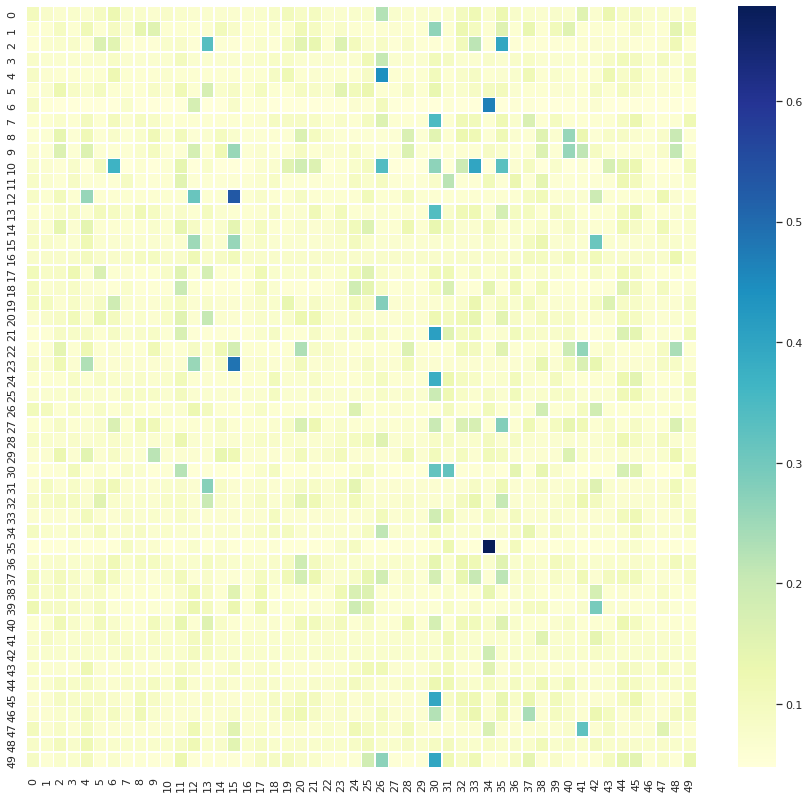

In [43]:
sns.set (rc = {'figure.figsize':(15, 14)})
sns.heatmap(df_adj, linewidths=.5, cmap='YlGnBu')#, vmax=0.6786438, vmin=0)


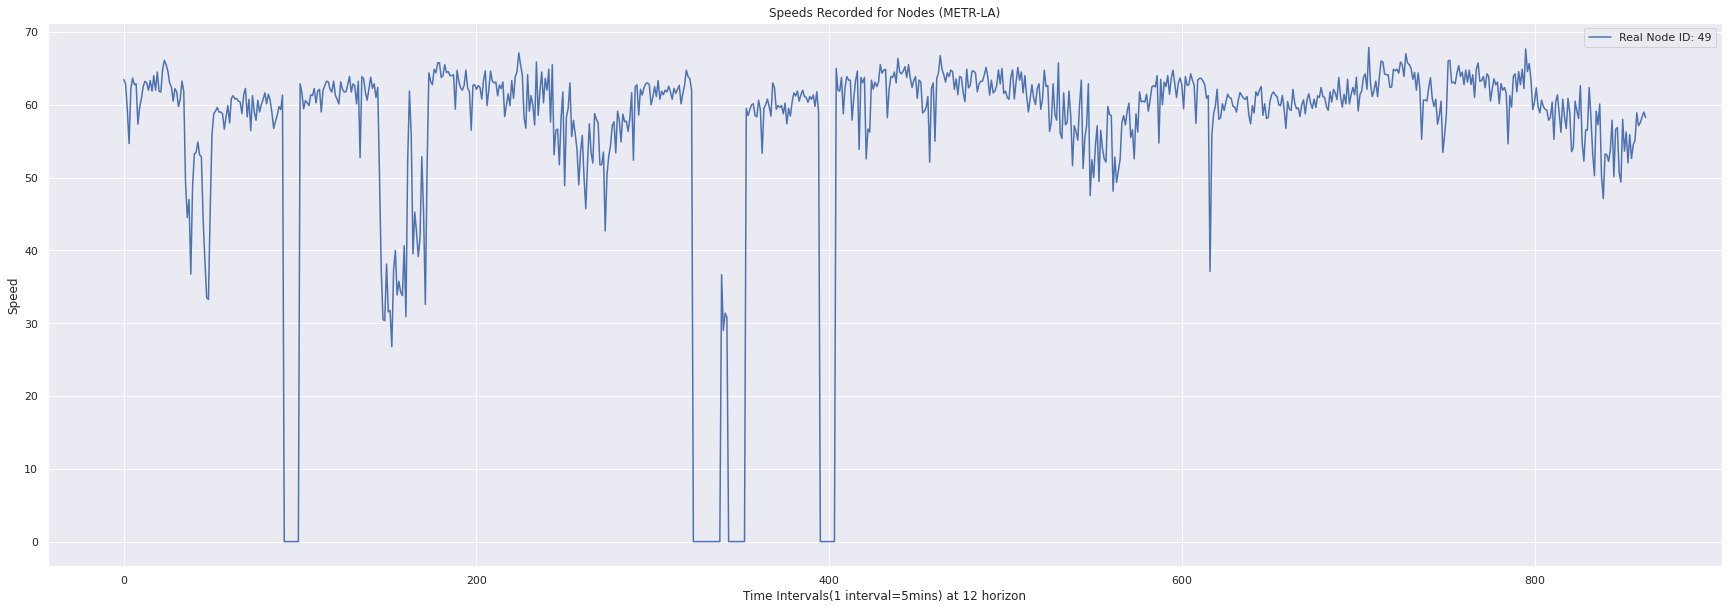

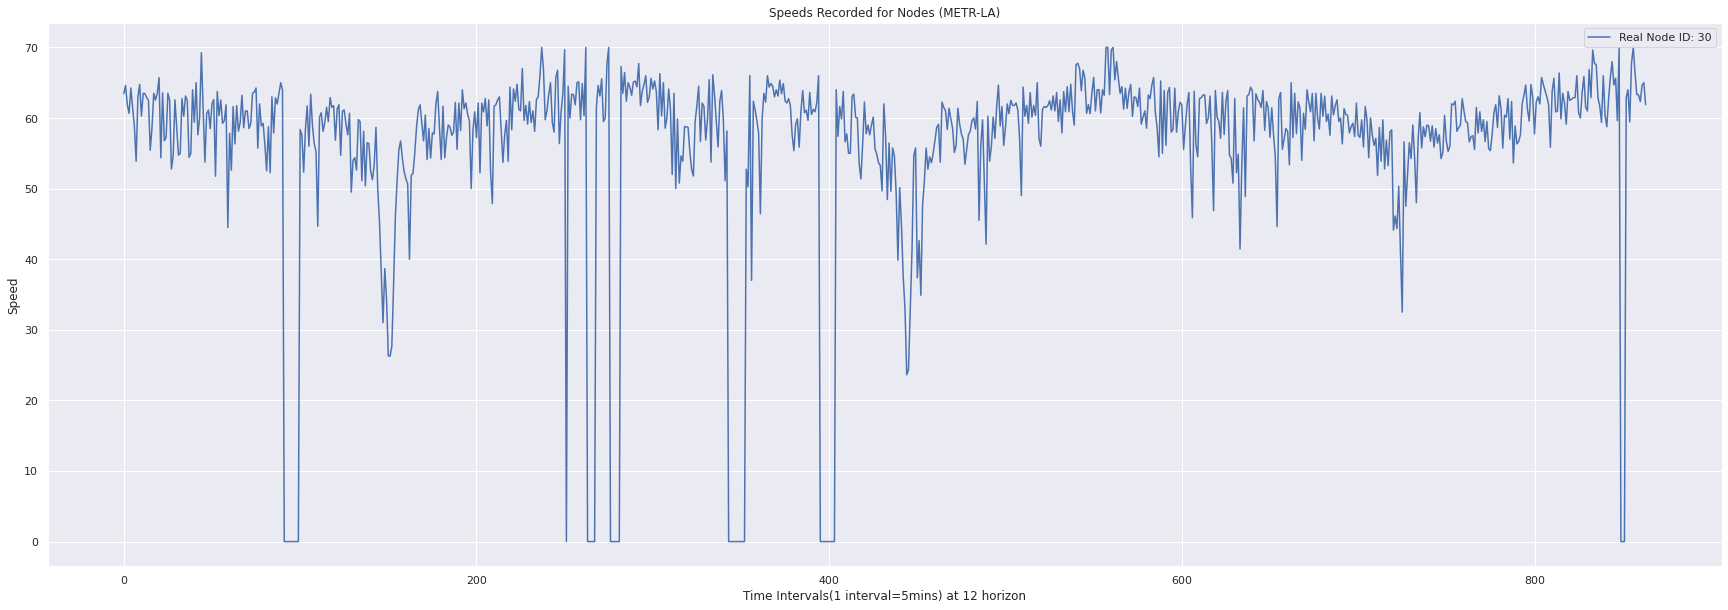

In [44]:
plot_time_compare(predList=predList, realList=realList, start=start, end=end, node_id=49, horizon=horizon, pred=False)
plot_time_compare(predList=predList, realList=realList, start=start, end=end, node_id=30, horizon=horizon, pred=False)

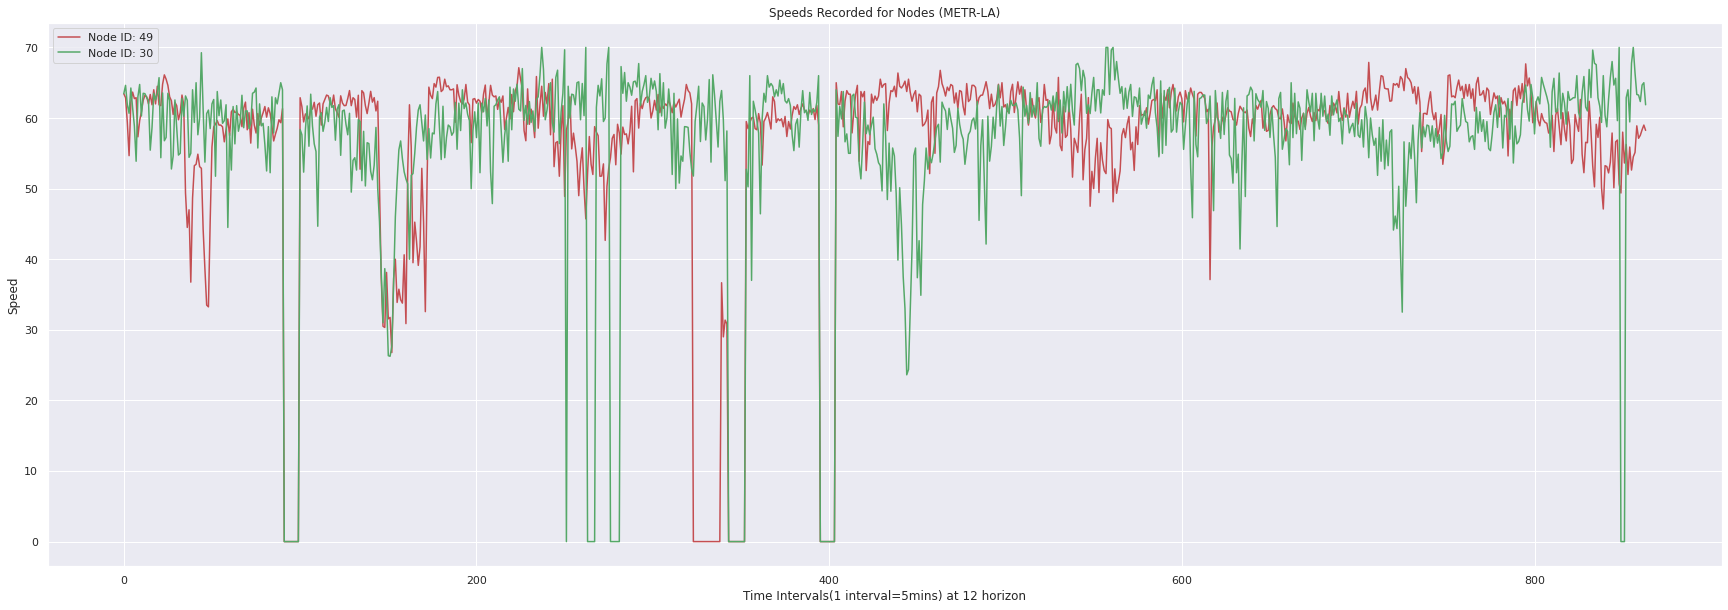

In [45]:
plot_dependencies(realList=realList, start=start, end=end, node_A=49, node_B=30, horizon=horizon)

## Fig 4 Real and Pred plots for node 65 and 30 as seen in the heatmap
- Node 65 influences node 30 as seen in the similar dips in their graphs.
